In [1]:
from priorloader import DataGenerator
from transform import affine_transform
from tensorflow.contrib.image import transform
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from python.dataloader import loader
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/home/barnrang/.conda/envs/chatbot/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
loader = DataGenerator()

100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


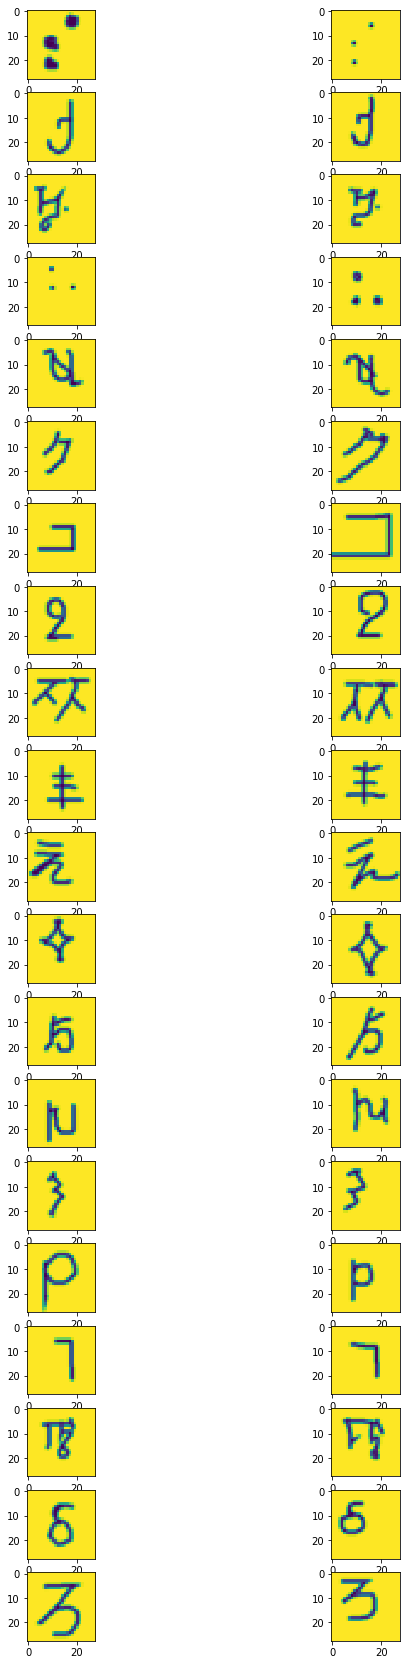

In [3]:
test = loader[0]
fig, axes = plt.subplots(20,2, figsize=(10,30))
for i in range(20):    
    axes[i][0].imshow(np.squeeze(test[0][0][i]))
    axes[i][1].imshow(np.squeeze(test[0][1][i]))
plt.show()

In [4]:
test = loader[0]
#plt.imshow(np.squeeze(test[0][0][0]))
test[1]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  

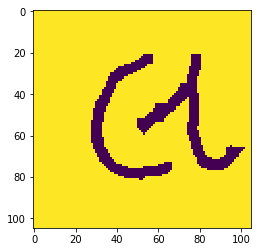

In [5]:
plt.imshow(np.squeeze(loader.class_data[0][0]))

In [18]:
input_img = tf.placeholder(shape=(None,105,105,1), dtype=tf.float32)
trans_img = affine_transform(input_img, 0.5)

<bound method Tensor.get_shape of <tf.Tensor 'cond_7/Merge:0' shape=(?, 105, 105, ?) dtype=float32>>


In [113]:
trans_img.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'transform_14/ImageProjectiveTransform:0' shape=(?, 105, 105, ?) dtype=float32>>

(105, 105, 1)


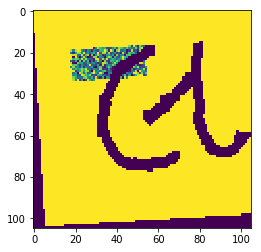

In [24]:
test_image = [loader.class_data[0][0]]
print(test_image[0].shape)
sess = tf.Session()
out_img = sess.run(trans_img, feed_dict={input_img:test_image})
plt.imshow(np.squeeze(out_img))

# Tensorflow Loader

In [21]:
data = loader(path='python/images_background_small1/')
dict_data = {i:x for i, x in enumerate(data) }
dataset = tf.data.Dataset.from_tensors(dict_data)
dataset = dataset.shuffle(1000).repeat().batch(10)

100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


# TFRecord

In [4]:
writer = tf.python_io.TFRecordWriter('TFRecord/train.tfrecords')

NotFoundError: TFRecord/train.tfrecords; No such file or directory

In [16]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [2]:
BASE_PATH = "python/images_background"
TRAIN_CLASS = 25
file_path = []
def loader(data_type='train',path=None):
    "TODO!!!!"
    #writer = tf.python_io.TFRecordWriter('TFRecord/train.tfrecords')
    with tf.python_io.TFRecordWriter('TFRecord/train.tfrecords') as writer:
        if path is None:
            path = BASE_PATH
        folders_list = os.listdir(path)
        folders_list.sort()
        idx = 0
        if data_type == 'train':
            folders_list = folders_list[:TRAIN_CLASS]
        else:
            folders_list = folders_list[TRAIN_CLASS:]
        for folder in tqdm(folders_list):
            path1 = os.path.join(path, folder)
            try: #In case of invalid folder
                for char_type in os.listdir(path1):
                    path2 = os.path.join(path1, char_type)
                    class_image = []
                    for image_name in os.listdir(path2):
#                         image = plt.imread(os.path.join(path2, image_name)).astype(np.int8)
#                         image = np.expand_dims(image, axis=-1)
#                         feature = {
#                             'image':_bytes_feature(image.tostring()),
#                             'label':_int64_feature(idx)
#                         }
#                         example = tf.train.Example(features=tf.train.Features(feature=feature))
#                         writer.write(example.SerializeToString())
                        class_image.append(os.path.join(path2, image_name))
                    file_path.append(class_image)
                    idx += 1
            except:
                continue

loader()

In [42]:
tf.reset_default_graph()
with tf.Session() as sess:
    data_path = 'TFRecord/train.tfrecords'

    feature = {
        'image':tf.FixedLenFeature([], tf.string),
        'label':tf.FixedLenFeature([], tf.int64)
        }
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    
    image = tf.decode_raw(features['image'], tf.int8)

    label = tf.cast(features['label'], tf.int32)
    
    image = tf.reshape(image, [105, 105, 1])
    images, labels = tf.train.shuffle_batch([image, label], 
                                            batch_size=30, capacity=30, num_threads=1, min_after_dequeue=10)
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    img, lbl = sess.run([images, labels])

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Session has been closed.


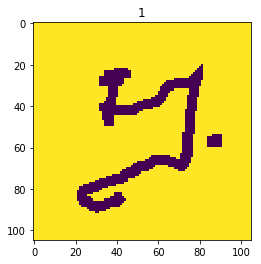

In [46]:
idx = 25
plt.imshow(np.squeeze(img[idx]))
plt.title(lbl[idx])
plt.show()

# TF Image Loader

In [2]:
BASE_PATH = "python/images_background"
TRAIN_CLASS = 25
file_path = []
def path_loader(data_type='train',path=None):
    "TODO!!!!"
    #writer = tf.python_io.TFRecordWriter('TFRecord/train.tfrecords')
    #with tf.python_io.TFRecordWriter('TFRecord/train.tfrecords') as writer:
    if path is None:
        path = BASE_PATH
    folders_list = os.listdir(path)
    folders_list.sort()
    idx = 0
    if data_type == 'train':
        folders_list = folders_list[:TRAIN_CLASS]
    else:
        folders_list = folders_list[TRAIN_CLASS:]
    for folder in tqdm(folders_list):
        path1 = os.path.join(path, folder)
        try: #In case of invalid folder
            for char_type in os.listdir(path1):
                path2 = os.path.join(path1, char_type)
                class_image = []
                for image_name in os.listdir(path2):
                    class_image.append(os.path.join(path2, image_name))
                file_path.append(class_image)
                idx += 1
        except:
            continue

path_loader()

100%|██████████| 25/25 [00:00<00:00, 58.77it/s]


In [3]:
file_path[0]

['python/images_background/Alphabet_of_the_Magi/character19/0727_14.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_18.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_15.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_19.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_17.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_05.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_11.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_06.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_04.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_09.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_12.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_03.png',
 'python/images_background/Alphabet_of_the_Magi/character19/0727_07.png',
 'python/images_background/Alphabet_of

In [7]:
tf.reset_default_graph()
img_str = tf.read_file(filename=file_path[0][0])
img = tf.image.decode_png(img_str)

In [8]:
with tf.Session() as sess:
    out_img = sess.run(img)
    out_img.shape

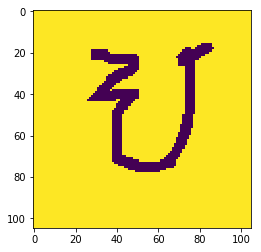

In [9]:
plt.imshow(np.squeeze(out_img))

# Tensorflow Load multiple file + transformation(tensorflow)

In [19]:
to_read = []
for i in range(20):
    to_read += file_path[i]
len(to_read) #images to read

400

## Load by Tensorflow

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Run call was cancelled


81.9143967628479


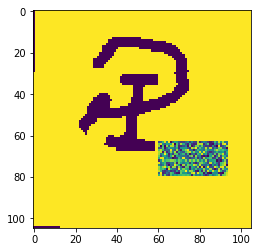

In [20]:
# Load by tensorflow

import time
tf.reset_default_graph()
file_queue = tf.train.string_input_producer(tf.convert_to_tensor(to_read, dtype=tf.string), shuffle=False)
batch_size = tf.constant(400) #Set batch size = len(to_read)
image_reader = tf.WholeFileReader()
_, images = image_reader.read(file_queue)
images = tf.image.decode_png(images)
images.set_shape([105,105,1])
image_batch = tf.train.batch((images,), batch_size=batch_size, capacity=20000)

# Affine Transformation + Random Erase (Check in transform.py)
image_batch = affine_transform(tf.cast(image_batch, dtype=tf.float32), 0.5)



with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    # Start machine
    images_batch = sess.run(image_batch)
    st = time.time()
    for i in range(1000):
        images_batch = sess.run(image_batch)
    ed = time.time()
print('\n')
print((ed - st))
plt.imshow(np.squeeze(images_batch[-1]))

## Load by numpy -> pass the batch through tensorflow transformation

94.98463726043701


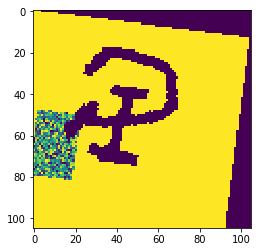

In [21]:
# Load directly from filepath
np_images_batch = []
tf.reset_default_graph()

# Set up transformation graph
tf_input = tf.placeholder(shape=[None, 105, 105, 1], dtype=tf.float32)
tf_out = affine_transform(tf_input, 0.5)

st = time.time()
with tf.Session() as sess:
    for i in range(1000):
        np_images_batch = []
        for path in to_read:
            np_images_batch.append(np.expand_dims(plt.imread(path).astype(np.float32),axis=-1))
        images_batch = sess.run(tf_out, feed_dict={tf_input:np_images_batch})
ed = time.time()
print((ed-st))
plt.imshow(np.squeeze(images_batch[-1]))